In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from time import perf_counter

In [2]:
# get and clean data
strokedata = pd.read_csv("stroke_data.csv")

# replacing null BMI values with median value
strokedata["bmi"].fillna(strokedata["bmi"].median(), inplace=True)
# drop instance with Other gender
strokedata = strokedata.drop(strokedata[strokedata["gender"] == "Other"].index)
# drop useless columns
strokedata = strokedata.drop(
    [
        "id",
        "work_type",
        "Residence_type",
        "ever_married",
        "gender"
    ],
    axis=1,
)
# create one-hot encoding
strokedata = pd.get_dummies(strokedata, columns=["smoking_status"])
strokedata = strokedata.drop(
    [
        "smoking_status_Unknown",
        "smoking_status_formerly smoked",
    ],
    axis=1,
)

# print(strokedata.columns)
# print(strokedata.describe())
# print(strokedata.head())

In [3]:
# Create Training and Testing Sets

# Splitting into training and testing sets
target = "stroke"
train_set, test_set = train_test_split(
    strokedata, test_size=0.15, stratify=strokedata[target], random_state=42
)

# Creating input and label data
X_train = train_set.drop(target, axis=1)
X_test = test_set.drop(target, axis=1)
y_train = train_set[target]
y_test = test_set[target]

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4130, 1: 212})
Counter({0: 730, 1: 37})


In [4]:
# preprocess
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# oversample
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({0: 4130, 1: 4130})


rbf {'C': 1, 'gamma': 10} [657  73  27  10] 97.32
poly {'coef0': 10, 'degree': 4} [569 161  16  21] 62.25
linear {'C': 0.01} [541 189   8  29] 13.37


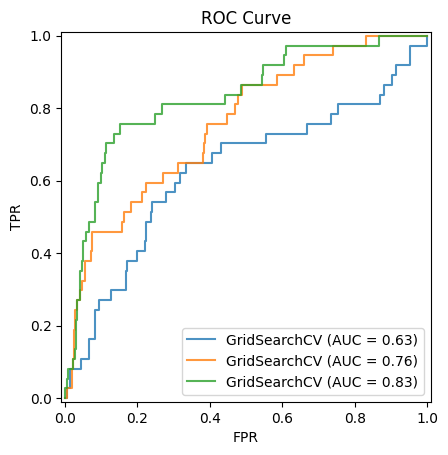

In [6]:
# grid search and make graph

param_grids = [
    {
        "C": [0.1, 1, 10, 100],
        "gamma": [10, 1, 0.1, 0.01, 0.001, 0.0001],
        "kernel": ["rbf"],
    },
    {
        # "C": [1],
        "coef0": [1, 10],
        "degree": [2, 3, 4],
        "kernel": ["poly"],
    },
    {
        "C": [0.01, 0.1, 10, 100],
        "kernel": ["linear"],
    },
]
ax = plt.gca()
scoring = "roc_auc"

for param_grid in param_grids:
    svm = GridSearchCV(SVC(), param_grid=param_grid, cv=2, verbose=0, scoring=scoring)

    t0 = perf_counter()
    svm.fit(X_train, y_train)
    t1 = perf_counter()

    del svm.best_params_["kernel"]
    kernel = param_grid["kernel"][0]
    print(
        kernel,
        svm.best_params_,
        confusion_matrix(y_test, svm.predict(X_test)).ravel(),
        round(t1 - t0, 2),
    )
    RocCurveDisplay.from_estimator(svm, X_test, y_test, ax=ax, alpha=0.8)

plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

<Axes: title={'center': 'feature importance'}>

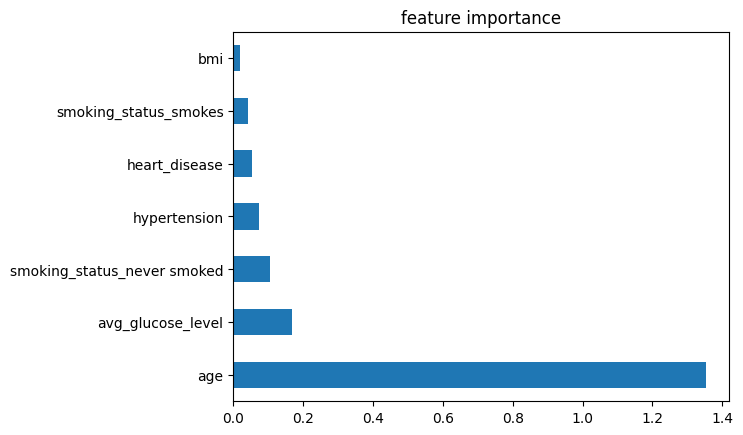

In [ ]:
# create feature importance

svm = SVC(C=0.01, kernel="linear")
svm.fit(X_train, y_train)

features = strokedata.columns.tolist()
features.remove("stroke")

pd.Series(
    abs(svm.coef_[0]),
    index=features,
).nlargest(10).plot(kind="barh", title="feature importance")

In [ ]:
print(strokedata[strokedata.smoking_status_smokes == 1].describe())
print(strokedata[strokedata["smoking_status_never smoked"] == 1].describe())
print(strokedata.describe())

              age  hypertension  heart_disease  avg_glucose_level         bmi  \
count  789.000000    789.000000     789.000000         789.000000  789.000000   
mean    47.096324      0.119138       0.077313         108.017440   30.382510   
std     16.413002      0.324156       0.267257          47.280803    6.977593   
min     10.000000      0.000000       0.000000          55.320000   15.700000   
25%     33.000000      0.000000       0.000000          77.190000   25.800000   
50%     47.000000      0.000000       0.000000          93.880000   28.700000   
75%     59.000000      0.000000       0.000000         114.470000   34.100000   
max     82.000000      1.000000       1.000000         271.740000   78.000000   

           stroke  
count  789.000000  
mean     0.053232  
std      0.224638  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000  
               age  hypertension  heart_disease  avg_glucose_level  \
count  1892.000000  